In [ ]:
#{"username":"berkaytellkavak","key":"77722ac16c67e6b68bd5d6fd1878a25c"}

In [ ]:
#Drive ile Colab'ın bağlanmasını sağlıyor.
#Bu sayede drive içinde bulunan dosyalara veya veri setlerine ulaşabiliyoruz.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Drive içinde bulunan dosyaları görmek amacıyla kullanıyoruz.
#Koda bir katkısı yok.
!ls '/content/drive/MyDrive'

'-_BILIM YUNUSEMRE BERKAY.jpg'	'Colab Notebooks'  'Mls Tanıtım günü'   opencv


In [ ]:
#Tensorflow kütüphanesini import ediyoruz.
#Ardından tensorflow ve keras kütüphanelerinden layers'a ait sınıfları import ediyoruz.
#bu sınıflar önceden eğitilmiş katmanlar olduğu için ağırlıklarını yeni bir görevde kullanabiliriz.
#Transfer öğrenme,önceden eğitilmiş modelin bir kısmını alıp
#üzerine yeni bir katman kurulması ile inşa edilir.
#matplot ise verilerin görselleştirilmesi aşamasında kullanılır.
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Dense, Flatten, \
                                    Concatenate, GlobalMaxPooling2D, \
                                    MaxPooling2D, GlobalAveragePooling2D, \
                                    AveragePooling2D

import matplotlib.pyplot as plt

tf.__version__

'2.12.0'

In [ ]:
#veri setlerini yükleme
#Fish_Dataset -> Eğitim(Train) için kullanılacak olan
#NA_Fish_Dataset -> Test verisi olarak kullanılacak olan
#valid_set -> Validation (doğrulama) verisi olarak kullanılacak olan
train_dir = "/content/drive/MyDrive/dataset/Fish_Dataset/Fish_Dataset"
validation_dir ="/content/drive/MyDrive/dataset/valid_set"
test_dir = "/content/drive/MyDrive/dataset/NA_Fish_Dataset"

In [ ]:
#tf.keras.utils.image_dataset_from_directory() işlemini veri setinin yüklenmesi
#için kullanıyoruz.Bu işlem dizindeki görüntüleri yükleyip,dataset nesnesine dönüştürür.
#image_size parametresi,yüklenen görüntülerin boyutunu belirler.
#batch_size parametresi,eğitim kümesinin her bir yinelemesinde
#kaç örneğin bir araya getirileceğini belirler.
image_size = (224, 224)
batch_size = 2

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_dir,
    image_size = image_size,
    batch_size = batch_size,
    label_mode='int',
    shuffle = True
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory = validation_dir,
    image_size = image_size,
    batch_size = batch_size,
    label_mode='int', # 0 1 2 3 4 ...
    shuffle = False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_dir,
    image_size = image_size,
    batch_size = batch_size,
    label_mode='int',
    shuffle = False
)
#classes,eğitim veri kümesindeki sınıf isimlerini içeren bir liste gibidir.
classes = train_ds.class_names

Found 4504 files belonging to 9 classes.
Found 450 files belonging to 9 classes.
Found 450 files belonging to 9 classes.


In [ ]:
#train_ds.cache() işlevi, eğitim veri kümesinin önbelleğe alınmasını sağlar.
#Önbelleğe alma,veri kümesinin diskten tekrar tekrar yüklenmesini önler ve
#verinin okunma süresini azaltır.
#tf.data.AUTOTUNE işlevi ise,veri kümesinin eğitimde asenkron yüklenmesini sağlar.
#Tensorflow'a otomatik olarak en iyi ayarları seçme yetkisini tanır.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
#visualize_dataset fonksiyonu, bir veri kümesindeki örnekleri
#görselleştirmek için kullanılır.
#Fonksiyon, veri kümesinden alınan bir batch'teki görüntüleri ve etiketleri
#kullanarak bir matplotlib subplot'u oluşturur.
#Her subplot, plt.imshow işlevi kullanılarak görüntülenir.
def visualize_dataset(dataset: tf.data.Dataset):
    plt.figure(figsize=(24,18))
    for images, labels in dataset.take(1):
        for i in range(64):
            plt.subplot(8, 8, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(classes[labels[i].numpy()])
            plt.axis('off')

In [ ]:
#toplam sınıf sayısını belirtir.
total_classes = len(classes)
total_classes

9

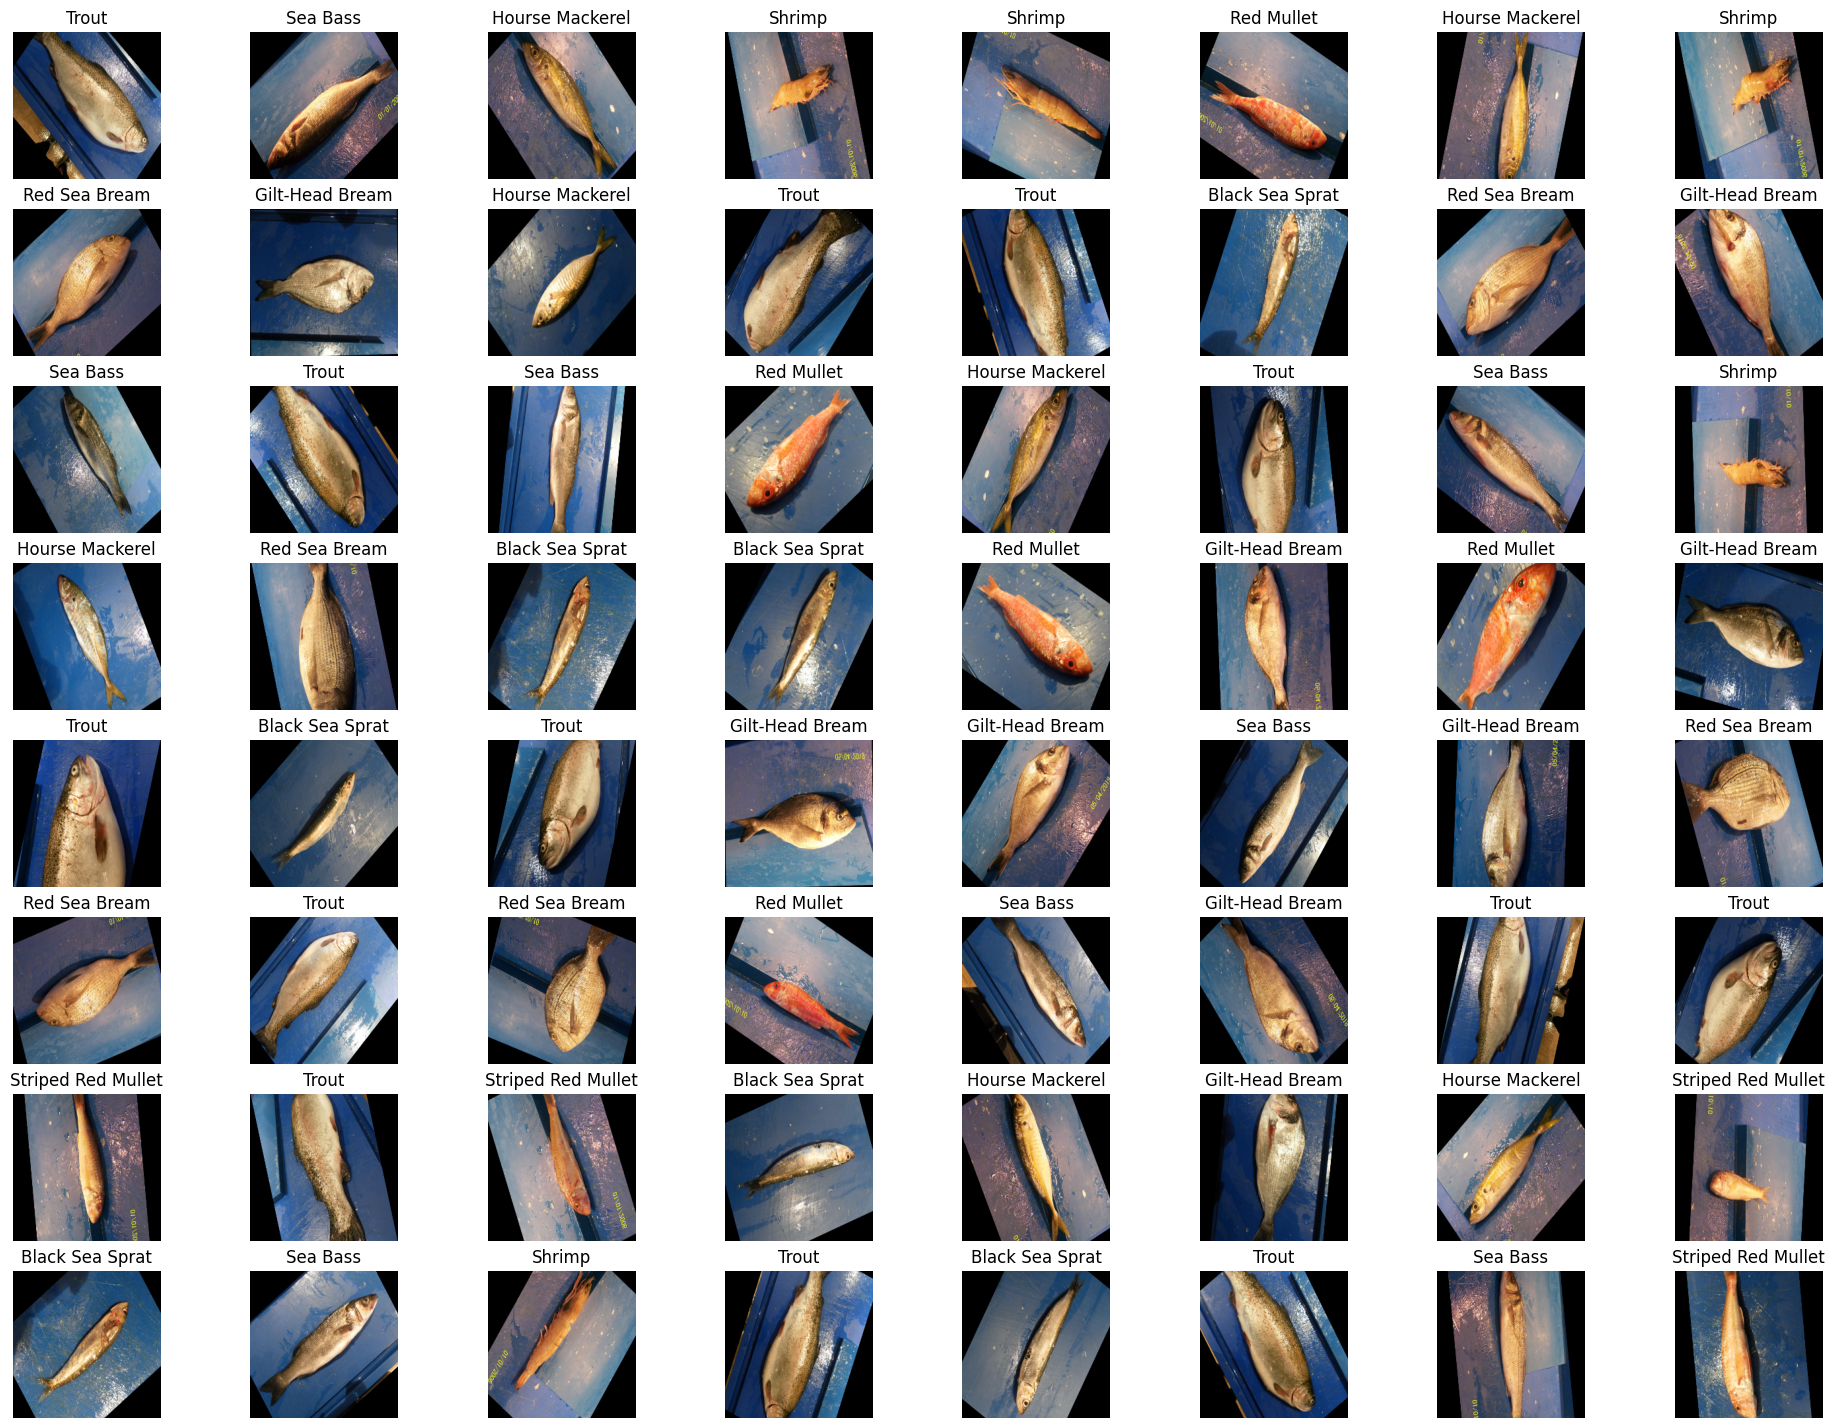

In [ ]:
#Veri setimizi görmemizi sağlıyor.
visualize_dataset(train_ds)

In [ ]:
#Transfer Learning için keras kütüphanesinden DenseNet121 import ediliyor.
#Giriş katmanı(input layer) 224x224 renkli(RGB) görüntüler için
#preprocess kısmı görüntüleri DenseNet121 modeline uygun önişleme yapmak için
#kullanılır.

from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

input_layer = tf.keras.Input((224, 224, 3))
preprocessed_inputs = tf.keras.layers.Lambda(lambda x: preprocess_input(x))(input_layer)

In [ ]:
#weights = "imagenet" -> Modelin ağırlıklarının ImageNet veri kümesi
#üzerinde önceden eğitilmiş ağırlıklar olmasını sağlar.Bu da performansı artırır.
#preprocessed_input, önceden işlenmiş görüntü verilerini temsil eder.


base_model = DenseNet121(
    weights = "imagenet",
    include_top = False,
    input_tensor = preprocessed_inputs
)
base_model


In [ ]:
#base_model'in son katmanından elde edilen çıktıları ifade eder.
base_model.output

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'relu')>

In [ ]:
#önceden eğitilmiş bir base_model üzerinde GlobalAveragePooling2D ve Dense
#katmanlarını ekleyerek transfer öğrenme için özelleştirilmiş bir model oluşturur.
#tl_model.summary ifadesi ise oluşturulan modelin özetini gösterir.
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(total_classes)(x)

tl_model = tf.keras.Model(inputs=input_layer, outputs=x)
tl_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['lambda_1[0][0]']               
 D)                                                                                               
                                                                                            

In [ ]:
#transfer öğrenme modelinin eğitimini ve model performansını iyileştirmek için
#kullanılan bazı geriçağırımları (callbacks) tanımlar.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.1,
    patience = 3,
    mode = "min",
    verbose = 1,
    min_lr = 1e-8
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 7,
    mode = "min",
    verbose = 1,
    restore_best_weights = True
    )

callbacks = [reduce_lr, early_stopping]

tl_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  optimizer = "adam",
                  metrics = ["acc"])

tl_model.fit(train_ds,
            epochs = 50,
            validation_data = valid_ds,
            callbacks = callbacks)

Epoch 1/50
2252/2252 [==============================] - 269s 91ms/step - loss: 1.5033 - acc: 0.5009 - val_loss: 1.5937 - val_acc: 0.4689 - lr: 0.0010
Epoch 2/50
2252/2252 [==============================] - 169s 75ms/step - loss: 0.7029 - acc: 0.7780 - val_loss: 2.2869 - val_acc: 0.5000 - lr: 0.0010
Epoch 3/50
2252/2252 [==============================] - 176s 78ms/step - loss: 0.3997 - acc: 0.8790 - val_loss: 1.7399 - val_acc: 0.6556 - lr: 0.0010
Epoch 4/50
2252/2252 [==============================] - 172s 76ms/step - loss: 0.2538 - acc: 0.9185 - val_loss: 1.2791 - val_acc: 0.6578 - lr: 0.0010
Epoch 5/50
2252/2252 [==============================] - 169s 75ms/step - loss: 0.1582 - acc: 0.9514 - val_loss: 0.9267 - val_acc: 0.7333 - lr: 0.0010
Epoch 6/50
2252/2252 [==============================] - 168s 75ms/step - loss: 0.1307 - acc: 0.9580 - val_loss: 2.3054 - val_acc: 0.6244 - lr: 0.0010
Epoch 7/50
2252/2252 [==============================] - 168s 75ms/step - loss: 0.0959 - acc: 0.9700 

In [ ]:
#modelin test edilmesi için kullanılır.
tl_model.evaluate(test_ds)

225/225 [==============================] - 88s 391ms/step - loss: 1.5383 - acc: 0.8244


[1.538341999053955, 0.8244444727897644]